# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [26]:
# Load pickled data
import pickle
import os

data_folder = os.path.join(os.getcwd(), "traffic-signs-data")
training_file = os.path.join(data_folder, "train.p")
validation_file = os.path.join(data_folder, "valid.p")
testing_file = os.path.join(data_folder, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train_raw = train['features'], train['labels']
X_valid_raw, y_valid = valid['features'], valid['labels']
X_test_raw, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [27]:
### Replace each question mark with the appropriate value.
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(y_train_raw)

# Number of validation examples
n_validation = len(y_valid)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train_raw[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train_raw))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

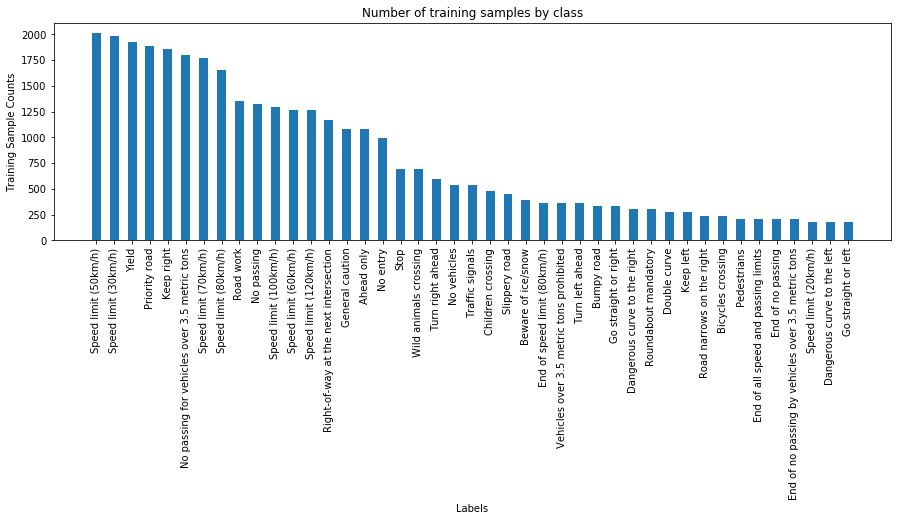

In [28]:
### Data exploration visualization code
import matplotlib.pyplot as plt
import csv

# Count the number of training samples in each class
train_count_by_class = [0] * n_classes
for sample in y_train_raw:
    train_count_by_class[sample] += 1

# Extract the label text from "signnames.csv"
class_labels_text = list(range(n_classes))
with open("signnames.csv", 'r') as csvfile:
    signnames_reader = csv.reader(csvfile, delimiter=',')
    # skip the header
    next(signnames_reader)
    for row in signnames_reader:
        class_labels_text[int(row[0])] = str(row[1])

# Sorting the classes from the most numerous to the least
train_count_by_class = list(zip(class_labels_text, train_count_by_class))
sorted_train_count_by_class = sorted(train_count_by_class, key=lambda x: x[1], reverse=True)
sorted_train_count_by_class = list(zip(*sorted_train_count_by_class))

# Plot the sample counts vs labels graph
plt.figure(figsize=(15,4))
plt.bar(range(len(sorted_train_count_by_class[1])), sorted_train_count_by_class[1], 0.5)
plt.xlabel("Labels")
plt.ylabel("Training Sample Counts")
plt.title("Number of training samples by class")
plt.xticks(range(len(sorted_train_count_by_class[0])), sorted_train_count_by_class[0], rotation="vertical")
plt.show()

The number of samples among the different classes is very unbalanced. This can cause overfitting with the over-represented class and it might not be able to predict under-represented classes well. 
To alleviate this problem, I oversampled the under-represented classes with added noise.

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set
Here I oversampled the training samples to make all classes so that each class has the sample number of samples. I added "salt and pepper" noise to the additional samples to reduce over-fitting. Note that noisy images are added to the classes with most samples as well.

In addition, I greyscale the images to reduce the number of features. This allows the use of neural network with fewer parameters and requires fewer training samples. 

Example of images with added noise.


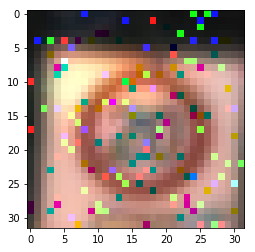

Number of training examples after augmentation = 103716
Image shape after preprocessing =  (32, 32, 1)


In [29]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include
### converting to grayscale, etc.
import numpy as np
from skimage.util import random_noise
from sklearn.utils import shuffle
from collections import defaultdict

# Put samples in a dictionary categorized by class
X_train_by_class = defaultdict(list)
for i in range(len(X_train_raw)):
    X_train_by_class[y_train_raw[i]].append(X_train_raw[i])

# Add noisy version of the sample until all classes have the sample number of samples
# Add 20% noisy images even for the class with the most samples.
max_sample_count = int(sorted_train_count_by_class[1][0]*1.2)
for class_id, class_samples in X_train_by_class.items():
    num_samples = len(class_samples)
    num_samples_still_needed = max_sample_count - num_samples
    template_ids = np.random.choice(range(0, num_samples), num_samples_still_needed)
    noisy_images = []
    for template_id in template_ids:
        noisy_image = random_noise(class_samples[template_id], mode="s&p")
        noisy_images.append(noisy_image)

    # add the noisy_image to the dict
    class_samples += noisy_images
    X_train_by_class[class_id] = class_samples

print("Example of images with added noise.")
plt.figure(figsize=(4, 4))
plt.imshow(X_train_by_class[0][-1])
plt.show()

# Turn the dict back to array again
X_train_augmented = []
y_train_augmented = []
for class_id, class_samples in X_train_by_class.items():
    X_train_augmented += class_samples
    y_train_augmented += [class_id] * len(class_samples)

n_train = len(X_train_augmented)
print("Number of training examples after augmentation =", n_train)

# Greyscale the training and validation images
X_train = np.mean(X_train_augmented, axis=3)
X_train = X_train.reshape(X_train.shape + (1,))
y_train = y_train_augmented

X_valid = np.mean(X_valid_raw, axis=3).squeeze()
X_valid = X_valid.reshape(X_valid.shape + (1,))

image_shape = X_train[0].shape
print("Image shape after preprocessing = ", image_shape)

# Shuffle the training samples
X_train, y_train = shuffle(X_train, y_train)


### Model Architecture
I modified the LeNet used in the MNIST example. The main change I made was to increase the depth of the first two convolutional layers to 32 and 64 respectively to account for the added complexity of the data. 
I also increased the number of epochs to 150 since there are more training samples and neurons (when compared to MNIST).
Moreover, I added a dropout layer to reduce over-fitting.

In [30]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    fc0 = flatten(conv2)
    
    # Layer 3: Fully Connected.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Dropout.
    h_fc2_drop = tf.nn.dropout(fc2, keep_prob)

    # Output Layer: Fully Connected.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(h_fc2_drop, fc3_W) + fc3_b

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [31]:
EPOCHS = 150
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None,) + image_shape)
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_classes)

rate = 0.0005
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Function for evaluating the accuracy of the prediction
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Training the neural network
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        if i % 10 == 0:
            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ...".format(i + 1), end="\t")
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))

    saver.save(sess, './traffic-sign-lenet')
    print("Model saved")


Training...

EPOCH 1 ...	Validation Accuracy = 0.229
EPOCH 11 ...	Validation Accuracy = 0.931
EPOCH 21 ...	Validation Accuracy = 0.956
EPOCH 31 ...	Validation Accuracy = 0.944
EPOCH 41 ...	Validation Accuracy = 0.955
EPOCH 51 ...	Validation Accuracy = 0.958
EPOCH 61 ...	Validation Accuracy = 0.954
EPOCH 71 ...	Validation Accuracy = 0.949
EPOCH 81 ...	Validation Accuracy = 0.961
EPOCH 91 ...	Validation Accuracy = 0.951
EPOCH 101 ...	Validation Accuracy = 0.962
EPOCH 111 ...	Validation Accuracy = 0.960
EPOCH 121 ...	Validation Accuracy = 0.957
EPOCH 131 ...	Validation Accuracy = 0.963
EPOCH 141 ...	Validation Accuracy = 0.961
Model saved


In [34]:
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    validation_accuracy = evaluate(X_valid, y_valid)

    print("EPOCH {} ...".format(EPOCHS), end="\t")
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))

INFO:tensorflow:Restoring parameters from .\traffic-sign-lenet
EPOCH 150 ...	Validation Accuracy = 0.962


INFO:tensorflow:Restoring parameters from .\traffic-sign-lenet
Test Accuracy = 0.943

Prediction on randomly selected test images
INFO:tensorflow:Restoring parameters from .\traffic-sign-lenet

Image # 0


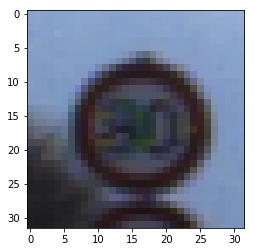

Prediction = Speed limit (80km/h)
Actual Label = Speed limit (80km/h)

Image # 1


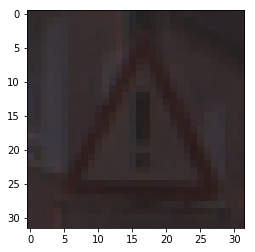

Prediction = General caution
Actual Label = General caution

Image # 2


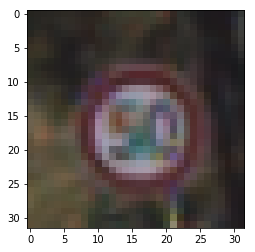

Prediction = Speed limit (50km/h)
Actual Label = Speed limit (50km/h)


In [35]:
# Make predictions of the class from the image
# If return_prob is true, it will return the raw softmax probability. 
# Else it returns the most likely prediction.
def predict(X_data, return_prob=False):
    sess = tf.get_default_session()
    predictions = sess.run(logits, feed_dict={x: X_data, keep_prob:1.0})
    if return_prob:
        return predictions
    else:
        return np.argmax(predictions, axis=1)

# Preprocessing: Grayscale the test image
X_test = np.mean(X_test_raw, axis=3).squeeze()
X_test = X_test.reshape(X_test.shape + (1,))

# Evaluate the accuracy of model by testing it with the test set.
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

# Pick three images from the test set.
random_image_ids = np.random.choice(n_test, 3)

# Make a prediction using the trained model.
print("\nPrediction on randomly selected test images")
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = predict(X_test[random_image_ids])
    for i in range(len(random_image_ids)):
        print("\nImage # %d" % i)
        plt.figure(figsize=(4, 4))
        plt.imshow(X_test_raw[random_image_ids[i]])
        plt.show()
        print("Prediction = %s" % class_labels_text[predictions[i]])
        print("Actual Label = %s" % class_labels_text[y_test[random_image_ids[i]]])

After training for 150 epochs, the accuracy on the validation set was approximately 0.962 and the accuracy on the test set was approximately 0.943. The model slightly over-fitted but the difference is relatively small.

---

## Step 3: Test a Model on New Images


### Load the Images

In [38]:
### Load the images and plot them here.
from skimage import io, transform

new_X_test_raw = []
new_X_test_name = []

data_folder = os.path.join(os.getcwd(), "traffic-signs-new-images")
for new_sample_image_file in os.listdir(data_folder):
    if new_sample_image_file.endswith(".jpg"):
        new_sample_image = io.imread(os.path.join(data_folder, new_sample_image_file))
        new_sample_image = transform.resize(new_sample_image, X_test_raw[0].shape, mode="reflect")
        new_X_test_raw.append(new_sample_image)
        new_X_test_name.append(new_sample_image_file)

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from .\traffic-sign-lenet

Filename = bicycle.jpg


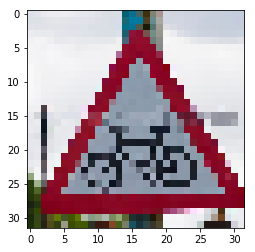

Top 5 Predictions (Label -- Softmax Probability)
	 Ahead only -- 1.14582
	 Bicycles crossing -- -0.354429
	 Children crossing -- -4.57259
	 Slippery road -- -6.26757
	 Speed limit (60km/h) -- -6.53344
An image of the same class in the training sample: 


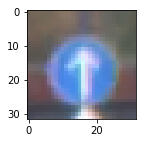


Filename = deer-sign.jpg


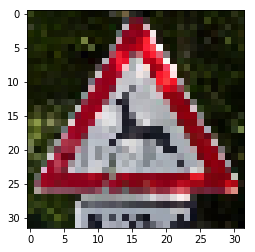

Top 5 Predictions (Label -- Softmax Probability)
	 Wild animals crossing -- 5.51297
	 Slippery road -- -0.466942
	 No passing for vehicles over 3.5 metric tons -- -9.11336
	 Dangerous curve to the left -- -12.5807
	 Road work -- -15.5678
An image of the same class in the training sample: 


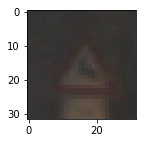


Filename = go-straight-or-right.jpg


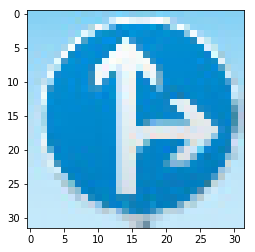

Top 5 Predictions (Label -- Softmax Probability)
	 Go straight or right -- 17.6862
	 Dangerous curve to the left -- -18.5981
	 Road work -- -18.6661
	 General caution -- -22.9936
	 Bicycles crossing -- -23.2801
An image of the same class in the training sample: 


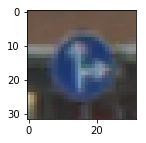


Filename = pedestrian.jpg


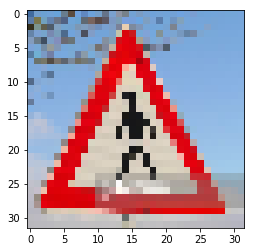

Top 5 Predictions (Label -- Softmax Probability)
	 Pedestrians -- 26.7529
	 Right-of-way at the next intersection -- 15.7218
	 General caution -- -8.36611
	 Roundabout mandatory -- -21.1614
	 Vehicles over 3.5 metric tons prohibited -- -25.2543
An image of the same class in the training sample: 


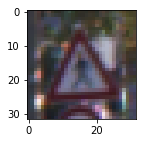


Filename = roadwork.jpg


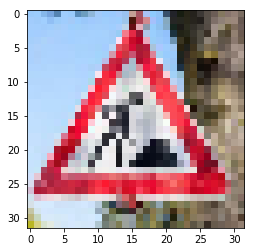

Top 5 Predictions (Label -- Softmax Probability)
	 Road work -- 15.2368
	 Dangerous curve to the right -- -8.52853
	 Beware of ice/snow -- -19.1516
	 No passing for vehicles over 3.5 metric tons -- -28.595
	 Wild animals crossing -- -30.0119
An image of the same class in the training sample: 


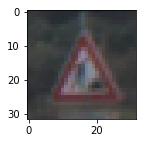


Filename = stop.jpg


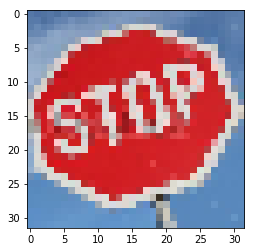

Top 5 Predictions (Label -- Softmax Probability)
	 Stop -- 2.01156
	 Speed limit (30km/h) -- -4.08149
	 Speed limit (70km/h) -- -4.47525
	 Turn right ahead -- -4.87525
	 Roundabout mandatory -- -6.19679
An image of the same class in the training sample: 


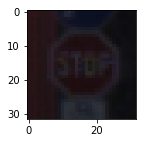

In [39]:
### Run the predictions here and use the model to output the prediction for each image.
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    # Grayscale the test image
    new_X_test = np.mean(new_X_test_raw, axis=3).squeeze()
    new_X_test = new_X_test.reshape(new_X_test.shape + (1,))

    predictions_probs = predict(new_X_test, return_prob=True)
    predictions = np.argmax(predictions_probs, axis=1)

    for i in range(len(predictions)):
        print("\nFilename = %s" % new_X_test_name[i])
        plt.figure(figsize=(4, 4))
        plt.imshow(new_X_test_raw[i])
        plt.show()

        top_five = sorted(range(len(predictions_probs[i])), key=lambda x: predictions_probs[i][x], reverse=True)[:5]
        print("Top 5 Predictions (Label -- Softmax Probability)")
        for index in top_five:
            print("\t", class_labels_text[index], "--", predictions_probs[i][index])

        print("An image of the same class in the training sample: ")
        plt.figure(figsize=(2, 2))
        plt.imshow(X_train_by_class[top_five[0]][0])
        plt.show()

### Analyze Performance

Out of the 6 new images that I found on the web, I got 5 of them right. This gives the model an accuracy of 0.83 for new images. This is low compared to the accuracy on the test set. 


The one that my model got wrong is "Bicycle Crossing". The confidence on the incorrectly classified images are relatively low. Samples in the test set might be relative similar which caused the overfitting.

The images below showed an example of the this class in our training set.
Due to small size and fine details in the images, a 32x32 sample is very pixelated and it is even difficult for human being to tell what the signs are. This might have contributed to the incorrect preditcions. 

Bicycle Crossing in training sample


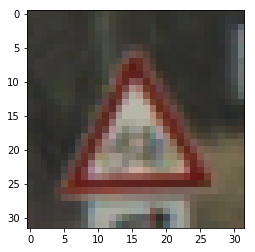

In [41]:
print("Bicycle Crossing in training sample")
plt.imshow(X_train_by_class[29][32])
plt.show()